In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from src.models.classification.evaluate_models import ClassificationAnalysis
from src.models.classification.train_models import ClassificationTraining
from src.visualization.styles.formatting import errorbar_kwargs

In [2]:
samples_per_composition = 30

training = ClassificationTraining(samples_per_composition=samples_per_composition)
analysis = ClassificationAnalysis(samples_per_composition=samples_per_composition)

results = training.load_training_models()
indices = analysis.load_performance_indices()

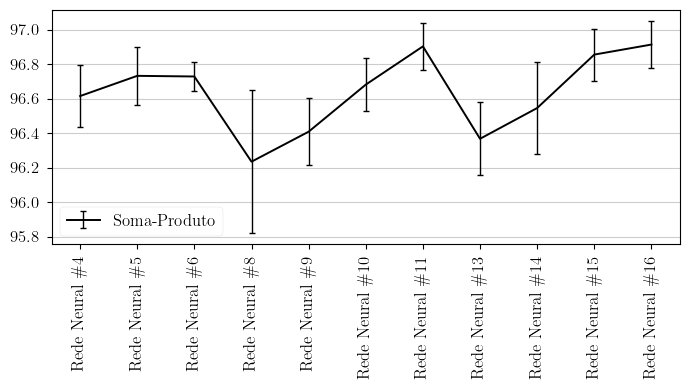

In [3]:
name = "sp_index"
# models = [i for i in range(19, 34)]
models = [21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33]

outputs = [output for i, output in enumerate(results["outputs"]) if i in models]
labels = [hp["model_name"].replace("#", "\#") for hp in outputs]
x = np.array([i + 1 for i in np.arange(len(outputs))])

f, ax = plt.subplots(figsize=(7, 4))

y = indices[name][:, models].mean(axis=0) * 100
y_err = (indices[name][:, models].std(axis=0) / np.sqrt(10 - 1)) * 100
ax.errorbar(x, y, y_err, label="Soma-Produto", **errorbar_kwargs)
ax.yaxis.grid()
ax.set_xticks(x, labels, rotation=90, ha="center")
ax.legend(loc="lower left")

f.tight_layout()
# f.savefig(os.path.join("notebooks", f"{name}_errorbar_plot_alt.png"), dpi=600)

In [16]:
# Rede Neural #11 - Id: 28
# Rede Neural #15 - Id: 32
# Rede Neural #16 - Id: 33
#
# Wilcoxon test
# The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples
# come from the same distribution. In particular, it tests whether the distribution of the
# differences x - y is symmetric about zero. It is a non-parametric version of the paired
# T-test.
#
#   - alternative='two-sided': the distribution underlying d is not symmetric about zero.

from scipy import stats


def wilcoxon_test(sample1: np.ndarray, sample2: np.ndarray):
    d = np.around(sample1 - sample2, decimals=3)
    return stats.wilcoxon(d, alternative="two-sided")


print(wilcoxon_test(indices["sp_index"][:, 28], indices["sp_index"][:, 33]))
print(wilcoxon_test(indices["sp_index"][:, 32], indices["sp_index"][:, 33]))

WilcoxonResult(statistic=16.0, pvalue=0.43803541595496487)
WilcoxonResult(statistic=8.5, pvalue=0.6732899796599957)
